# Predict Spectra Example

Builds a simple baseline model for predicting solar spectrum in the range

    λ ∈ [830, 1800] nm 
    
from observed flux in the range 

    λ ∈ [300,  820] nm 
    
from a set of training spectra spanning the entire wavelength range. The model assumes that all training spectra are independent samples from a common multivariate normal distribution with a particularly simple structure, and the parameters of this distribution are estimated from data.

Let fᵢ: [300, 1800] nm → ℝ represent the ith training spectrum. We assume

   fᵢ ~(iid) N(μ, Σ) ∀i

Where μ is a mean spectrum and K is a covariance matrix specifying the correlation between flux in a given pair of wavelengths. We estimate μ and Σ from data.

* μ is estimated by taking a pointwise sample mean across the training
   spectra.
* Σ is estimated via PCA. Let M be the top-k principal components of the
   data; we estimate Σ = MMᵀ. Here we use k = 5 principal components.

With these parameters fixed, given observed flux in the range [300, 820] nm, we may condition the joint normal on this observed subvector to give a normal posterior belief about the remainder of the spectrum. This uses the standard conditioning formula for multivariate normal distributions.

Partition fᵢ as fᵢ = [f₁, f₂]ᵀ, where f₁ is the subvector corresponding to the observed portion of the spectrum and f₂ the remainder. Then if

   p(fᵢ) = N(μ, Σ)

we have

   p(f₂ | f₁) = N(μ₂ + Σ₂₁Σ₁₁⁻¹(f₁ - μ₁), Σ  - Σ₂₁Σ₁₁⁻¹Σ₁₂),

where we have partitioned μ and Σ in a similar manner to fᵢ. Now we may use the posterior mean as a point estimate of the remainder of the spectrum.

Contact Roman Garnett (garnett@wustl.edu) with any questions.


In [46]:
pkg load statistics

In [47]:
k = 5;         % number of components in covariance
jitter = 1e-6; % magnitude of diagonal contribution to covariance

In [48]:
% range of wavelengths in data
wavelengths = 300:10:1800; % nm

In [49]:
% goal is to predict [830, 1800] nm from columns [300, 820] nm
train_ind = find(wavelengths <= 820);
 test_ind = find(wavelengths  > 820);

In [50]:
% was produced with
% awk -F, '(NR > 3) {for (i = 9; i <= 158; i++) {printf $i " "} printf $159 "\n"}' 186_33.45_-111.98_tmy.csv > spectra
load('data/spectra');

In [51]:
% remove empty spectra
spectra = spectra(sum(spectra, 2) > 0, :);

In [52]:
% fit simple Gaussian model
mu = mean(spectra);

In [53]:
#[coefficients, ~, latent] = pca(spectra, 'numcomponents', k);
[coefficients, ~, latent] = princomp(spectra);
M = bsxfun(@times, coefficients(:, 1:k), sqrt(latent(1:k))');
K = M * M';
K = K + jitter * eye(size(K));
L = chol(K(train_ind, train_ind));

In [54]:
prefactor = K(test_ind, train_ind) / L / L';

posterior_mean = @(observed_flux) ...
    mu(test_ind)' + prefactor * (observed_flux - mu(train_ind))';

% if needed
posterior_covariance = ...
    K(test_ind, test_ind) - prefactor * K(train_ind, test_ind);

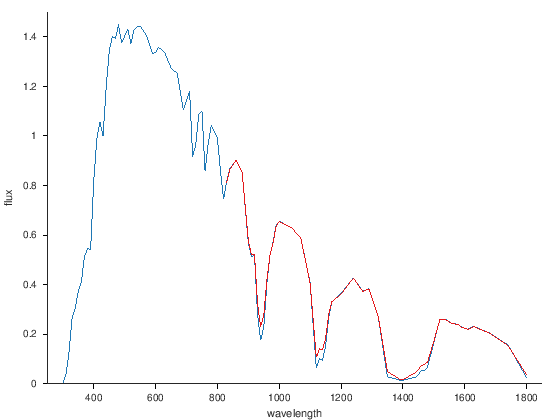

In [55]:
% plot example
ind = randi(size(spectra, 1));

figure(1);
clf;
plot(wavelengths, spectra(ind, :), ...
     'color', [31, 120, 180] / 255);
hold('on');
plot(wavelengths(test_ind), ...
     posterior_mean(spectra(ind, train_ind)), ...
     'color', [227, 26, 28] / 255);

ylim([0, 1.5]);
xlim([250, 1850]);

xlabel('wavelength');
ylabel('flux');

set(gca, 'box', 'off', 'tickdir', 'out');
